# 02. Comparing Experiments

**Note**: the appearance of this notebook will depend on the environment and screen size you're using. If the tables are being clipped or the figures look off, consider trying Google Colab or Github via the buttons below. This notebook was created in VSCode, and will likely look best locally.

<a target="_blank" href="https://colab.research.google.com/github/ioverho/bayes_conf_mat/blob/main/documentation/Getting%20Started/comparing_experiments.ipynb">
  <img alt="Static Badge" src="https://img.shields.io/badge/Run_in_Colab-_?style=for-the-badge&logo=googlecolab&labelColor=gray&color=1082c3&link=https%3A%2F%2Fgithub.com%2Fioverho%2Fbayes_conf_mat%2Fblob%2Fmain%2Fdocumentation%2FGetting%2520Started%2F02_comparing_experiments.ipynb">
</a>
<a target="_blank" href="https://github.com/ioverho/bayes_conf_mat/blob/main/documentation/Getting%20Started/comparing_experiments.ipynb">
  <img alt="Static Badge" src="https://img.shields.io/badge/View_in_Github-_?style=for-the-badge&logo=github&labelColor=gray&color=1082c3&link=https%3A%2F%2Fgithub.com%2Fioverho%2Fbayes_conf_mat%2Fblob%2Fmain%2Fdocumentation%2FGetting%2520Started%2F02_comparing_experiments.ipynb">
</a>

## Setup

Now consider the following common scenario. We train two different models, A and B, on the same dataset. Here model A is our baseline model, and B is the model we've brilliantly applied some intervention to. Now we want to test if our intervention helped classification performance. To do so, we apply the two models independently to the held-out test set and get the following confusion matrices:


In [1]:
confusion_matrix_a = [
    [2482, 75, 106, 59],
    [30, 3813, 423, 33],
    [22, 239, 3030, 7],
    [34, 13, 13, 191],
]

confusion_matrix_b = [
    [2508, 70, 102, 42],
    [22, 3820, 421, 36],
    [14, 202, 3071, 11],
    [37, 9, 6, 199],
]


To assess how much better model B is relative to model A, we use a classification metric on the two confusion matrices, for example Matthew's Correlation Coefficient (MCC). If the MCC is higher for model B, our intervention must have worked and we can publish our paper, right?

In [2]:
from bayes_conf_mat import Study

study = Study(
    seed=0,
    num_samples=10000,
    ci_probability=0.95,
)

study.add_experiment("a", confusion_matrix_a, prevalence_prior=1.0, confusion_prior=1.0)

study.add_experiment("b", confusion_matrix_b, prevalence_prior=1.0, confusion_prior=1.0)

study.add_metric(metric="mcc")


In [3]:
study.report_metric_summaries(metric="mcc")


Group,Experiment,Observed,Median,Mode,95.0% HDI,MU,Skew,Kurt
a,a,0.8523,0.8510,0.8502,"[0.8423, 0.8593]",0.0170,-0.0254,0.0868
b,b,0.8641,0.8628,0.8634,"[0.8546, 0.8706]",0.0160,-0.0713,0.0630


Indeed, when estimating MCC scores, it seems model B outperforms model A 0.0118. Before we get on with writing our pre-print, however, note that the credible intervals overlap at the 95% credibility level. So while model B is better, this is not always the case. This warrants additional testing.

## Bayesian Hypothesis Testing

In the frequentist framework, situations like these call for hypothesis tests on the means of the different samples, e.g., a t-test. We're not operating in the frequentist framework, however, and the distributions of the various metrics we can compute likely invalidate the stringent assumptions that go along with the hypothesis tests.

Instead, we can use a framework introduced by [Kruschke in Bayesian Estimation Supersedes the *t* Test](https://jkkweb.sitehost.iu.edu/articles/Kruschke2013JEPG.pdf). If we assume our samples from the two estimated posterior predictive distributions to be correct, we can estimate the difference between the two experiments by simply taking the differences of their samples. The produced difference distribution looks something like this:

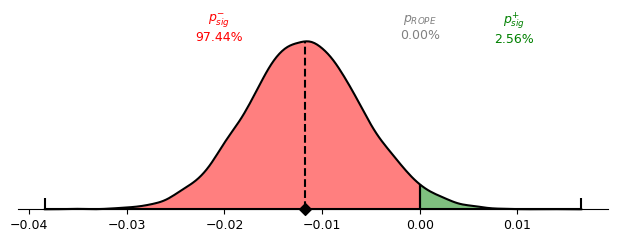

In [4]:
study.report_pairwise_comparison_plot(
    metric="mcc",
    experiment_a="a",
    experiment_b="b",
    min_sig_diff=0.0,
);


The area in red corresponds to area where model B is better than model A, and the region in green where model A actually remains better than model B. It's quite clear that model B is better *most of the time*, but is it enough to draw conclusions? Or do we need to test our models on a larger dataset? In other words, is this difference statistically significant, or just a 'lucky' outcome?

In [5]:
comparison_result = study.report_pairwise_comparison(
    metric="mcc",
    experiment_a="a",
    experiment_b="b",
    min_sig_diff=0.00,
)

print(comparison_result)


Experiment a's mcc being lesser than b could be considered 'likely'* (Median Δ=-0.0118, 95.00% HDI=[-0.0234, 4.9236e-05], p_direction=97.44%). There is a 100.00% probability that this difference is bidirectionally significant (ROPE=[-0.0000, 0.0000], p_ROPE=0.00%). Bidirectional significance could be considered 'certain'*. There is a 97.44% probability that this difference is significantly negative (p_pos=2.56%, p_neg=97.44%).

* These interpretations are based off of loose guidelines, and should change according to the application.


To test this, the first sentence of the above output is relevant. The median difference is -0.0118, with the true difference falling somewhere in the range \[-0.0234, 4.9236e-05\] at the 95% credibility level. The $p_{direction}$ statistic is most relevant, being somewhat comparable to the frequentist (complement of the) $p$-value. At a value of 97.44%, we can conclude that model B being better than model A is probable. More data is always better, but at currently there's only a 2.50% chance that model A actually remains better.

## The Region of Practical Equivalence (ROPE)

That covers statistical significance, but what about practical significance? The apparent gain that model B books over model A is... modest to say the least. Reviewers are likely not going to be too interested, unless we manage a $0.005$ increase.

On a larger enough test set, even very small differences become statistically significant, even when the models are *practically* equivalent. To test for practical significance, we can construct a Region of Practical Equivalence (ROPE). This is some region bounded by two minimally significant values, outside of which we may conclude that the difference between the models is worth noting.

For this example, let's assume that we only care about a difference in MCC if it's at least $0.005$. We can now repeat the analysis, while specifying the `min_sig_diff` parameter.

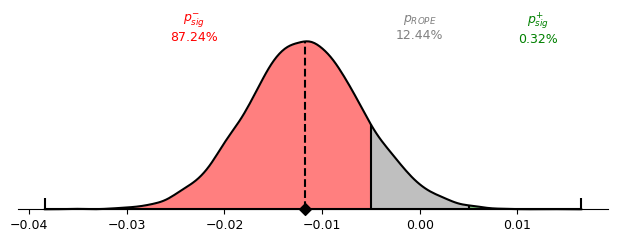

In [6]:
study.report_pairwise_comparison_plot(
    metric="mcc",
    experiment_a="a",
    experiment_b="b",
    min_sig_diff=0.005,
);


While model B still appears to be better than model A, there is ~13% probability that that difference is practically 0, or in favour of model A.

In [7]:
comparison_result = study.report_pairwise_comparison(
    metric="mcc",
    experiment_a="a",
    experiment_b="b",
    min_sig_diff=0.005,
)

print(comparison_result)


Experiment a's mcc being lesser than b could be considered 'likely'* (Median Δ=-0.0118, 95.00% HDI=[-0.0234, 4.9236e-05], p_direction=97.44%). There is a 87.56% probability that this difference is bidirectionally significant (ROPE=[-0.0050, 0.0050], p_ROPE=12.44%). Bidirectional significance could be considered 'undecided'*. There is a 87.24% probability that this difference is significantly negative (p_pos=0.32%, p_neg=87.24%). Relative to two random models (p_ROPE,random=47.75%) significance is 3.8384 times more likely.

* These interpretations are based off of loose guidelines, and should change according to the application.


If we don't care about the direction of significance (either model A or model B is better), practical significance is mostly undecided at an 87.56% probability. Most of this difference is in favour of model B (87.24%), though. When comparing to the difference between random models from the same dataset, we see that practical significance is 3.8 times more likely than not. Interpreting this as a Bayes Factor, this is usually seen as weak evidence.

All in all, while the difference likely does exist, it's not really large enough to celebrate just yet.

## Comparing to a Random Baseline

One important case to check is whether the trained classifier performs better than random. Initially, we would expect this to not be the case, but for any decent classifier, we would expect much better performance.

The random baseline largely depends on a) the classification metric used, and b) the label proportion. Luckily, the Study class can simulate performance of a random classifier on this dataset for any implemented metric. For example, if using the MCC metric, we would expect random performance to be 0 exactly.

In [8]:
study.report_random_metric_summaries(metric="mcc")


Group,Experiment,Median,Mode,95.0% HDI,MU,Skew,Kurt
a,a,-0.0001,-0.0011,"[-0.0107, 0.0114]",0.0220,0.0302,-0.0592
b,b,-0.0001,0.0003,"[-0.0108, 0.0111]",0.0219,0.0466,0.0479


And in fact, that is the value we retrieve. We can also see that most values fall within 0.01 MCC.

Given the previous results, it seems trivial to compare the trained classifiers to the random ones, but this is also implemented.

In [9]:
study.report_pairwise_comparison_to_random(metric="mcc", min_sig_diff=0.05)


Group,Experiment,Median Δ,p_direction,ROPE,p_ROPE,p_sig
a,a,0.8511,1.0000,"[-0.0500, 0.0500]",0.0000,1.0000
b,b,0.8629,1.0000,"[-0.0500, 0.0500]",0.0000,1.0000


Here we can see that for both 'trained' classifiers, the achieved classification performance is **much** better than random.

## Comparing Many Experiments

In [10]:
study.report_listwise_comparison(metric="mcc")


Group,Experiment,Rank 1,Rank 2
a,a,0.0256,0.9744
b,b,0.9744,0.0256


## Next Steps